In [2]:
%pip install git+https://github.com/huggingface/diffusers

  Cloning https://github.com/huggingface/diffusers to /tmp/pip-req-build-wb28mjxc
  Running command git clone --filter=blob:none --quiet https://github.com/huggingface/diffusers /tmp/pip-req-build-wb28mjxc
  Resolved https://github.com/huggingface/diffusers to commit 28f9d84549c0b1d24ef00d69a4c723f3a11cffb6
  Installing build dependencies ... - \ | done
  Getting requirements to build wheel ... - done
  Preparing metadata (pyproject.toml) ... - done
  Created wheel for diffusers: filename=diffusers-0.31.0.dev0-py3-none-any.whl size=2772952 sha256=844fd7de2ca66643ebc54f755f0d454c77c4212c169d3bf54fc1ff29dc64d456
  Stored in directory: /tmp/pip-ephem-wheel-cache-9lfc0_3e/wheels/f7/7d/99/d361489e5762e3464b3811bc629e94cf5bf5ef44dd5c3c4d52
Successfully built diffusers
  Attempting uninstall: huggingface-hub
    Found existing installation: huggingface-hub 0.23.0
    Uninstalling huggingface-hub-0.23.0:
      Successfully uninstalled huggingface-hub-0.23.0
  Attempting uninstall: di

In [1]:
from diffusers import AutoPipelineForText2Image
from diffusers.utils import load_image
import torch

pipeline = AutoPipelineForText2Image.from_pretrained("stabilityai/stable-diffusion-xl-base-1.0", torch_dtype=torch.float16).to("cuda")
pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")


/anaconda/envs/img/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Loading pipeline components...: 100%|██████████| 7/7 [01:25<00:00, 12.20s/it]
/anaconda/envs/img/lib/python3.10/site-packages/torch/_utils.py:776: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  return self.fget.__get__(instance, owner)()
/anaconda/envs/img/lib/python3.10/site-packages/huggingface_hub/file_download.py:1142: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=T

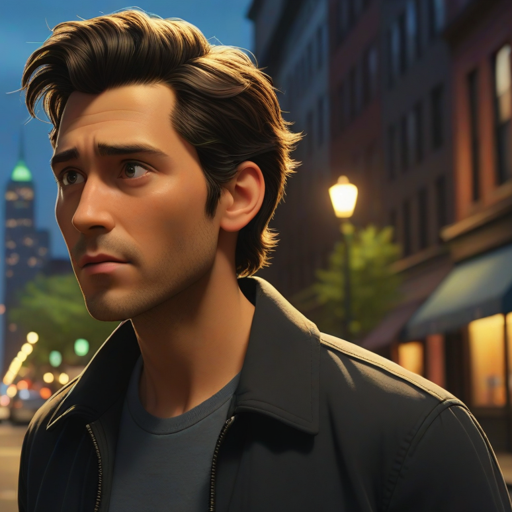

In [4]:
style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_image = load_image(f"{style_folder}/img7.png")

style_image.resize((512,512))

100%|██████████| 50/50 [00:06<00:00,  7.94it/s]


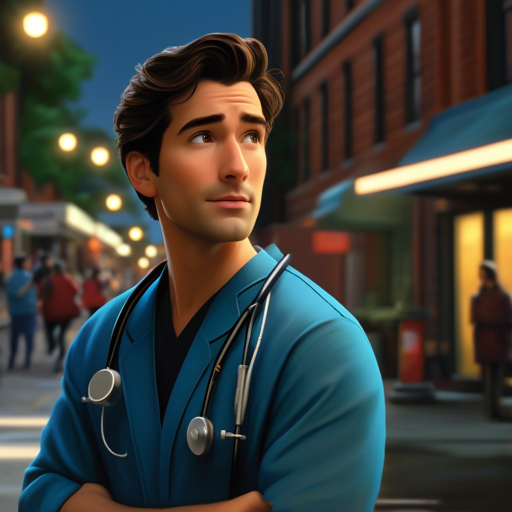

In [9]:
pipeline.set_ip_adapter_scale(0.8)

generator = torch.Generator(device="cuda").manual_seed(0)
images = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=style_image,
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
    generator=generator,
).images
images[0].resize((512,512))

## Apply IP Adapter only to style layer

100%|██████████| 50/50 [00:06<00:00,  8.16it/s]


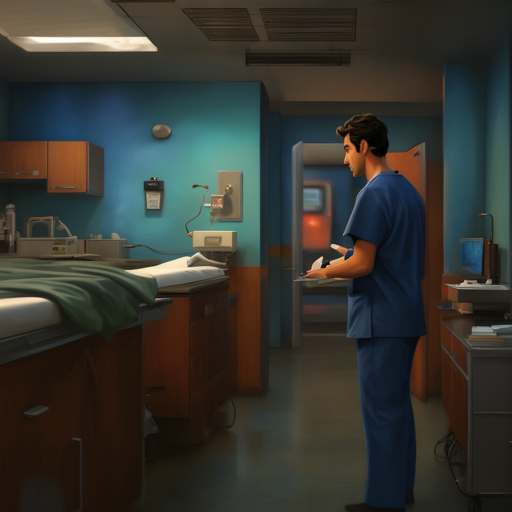

In [11]:
scale = {
    "up": {"block_0": [0.0, 1.0, 0.0]},
}

pipeline.set_ip_adapter_scale(scale)

generator = torch.Generator(device="cuda").manual_seed(26)

images = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=style_image,
    negative_prompt="deformed, ugly, wrong proportion, low res, bad anatomy, worst quality, low quality",
    num_inference_steps=50,
    generator=generator,
).images
images[0].resize((512,512))


### Using Ip Adapter with multiple images

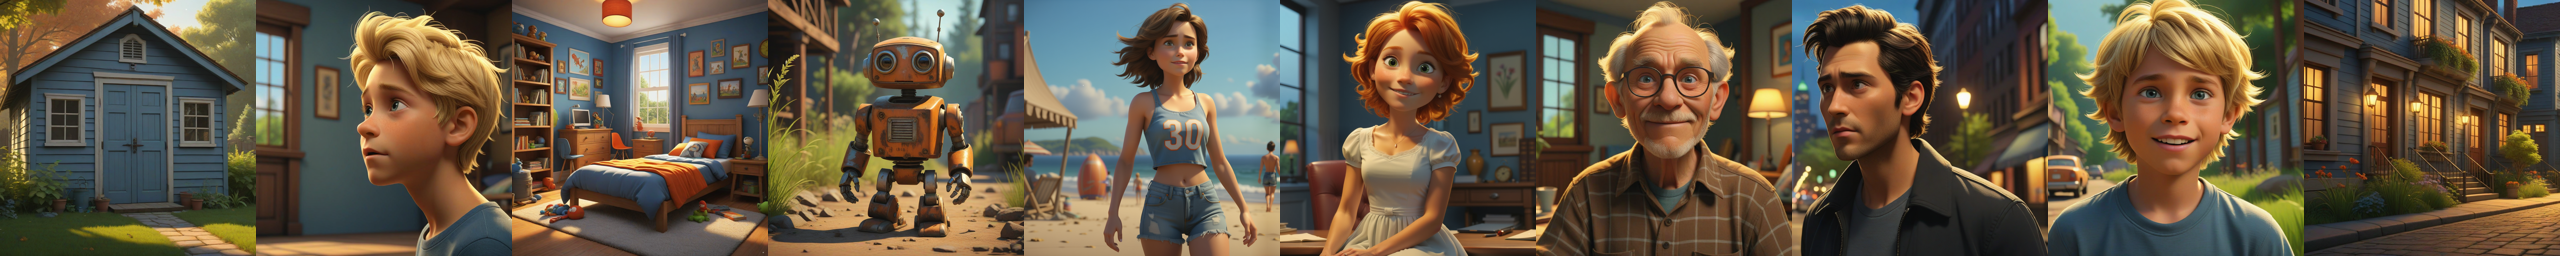

In [22]:
from PIL import Image

def image_grid(imgs, rows, cols, resize=256):
    assert len(imgs) == rows * cols

    if resize is not None:
        imgs = [img.resize((resize, resize)) for img in imgs]
    w, h = imgs[0].size
    grid = Image.new("RGB", size=(cols * w, rows * h))
    grid_w, grid_h = grid.size

    for i, img in enumerate(imgs):
        grid.paste(img, box=(i % cols * w, i // cols * h))
    return grid

style_images = [load_image(f"{style_folder}/img{i}.png") for i in range(10)]

num_imgs_to_preview = 10
image_grid(style_images[:num_imgs_to_preview], 1, num_imgs_to_preview)

100%|██████████| 50/50 [00:07<00:00,  6.48it/s]


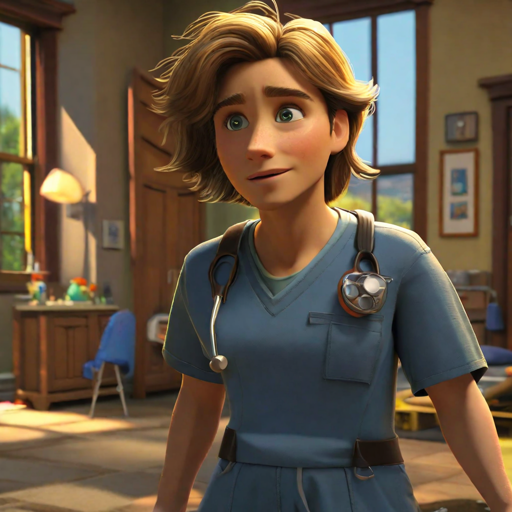

In [18]:
import torch
from diffusers import AutoPipelineForText2Image, DDIMScheduler
from transformers import CLIPVisionModelWithProjection
from diffusers.utils import load_image

image_encoder = CLIPVisionModelWithProjection.from_pretrained(
    "h94/IP-Adapter",
    subfolder="models/image_encoder",
    torch_dtype=torch.float16,
)

pipeline = AutoPipelineForText2Image.from_pretrained(
    "stabilityai/stable-diffusion-xl-base-1.0",
    torch_dtype=torch.float16,
    image_encoder=image_encoder,
)
pipeline.scheduler = DDIMScheduler.from_config(pipeline.scheduler.config)
pipeline.load_ip_adapter(
  "h94/IP-Adapter",
  subfolder="sdxl_models",
  weight_name="ip-adapter-plus_sdxl_vit-h.safetensors"
)
#pipeline.load_ip_adapter("h94/IP-Adapter", subfolder="sdxl_models", weight_name="ip-adapter_sdxl.bin")


scale = {
    "up": {"block_0": [0.0, 1.0, 0.0]},
}
pipeline.set_ip_adapter_scale(0.8)
pipeline.enable_model_cpu_offload()

style_folder = "https://huggingface.co/datasets/YiYiXu/testing-images/resolve/main/style_ziggy"
style_images = [load_image(f"{style_folder}/img{i}.png") for i in range(10)]

generator = torch.Generator(device="cpu")

image = pipeline(
    prompt="a doctor in blue scrubs in an emergency room",
    ip_adapter_image=[style_images],
    negative_prompt="lowres, bad anatomy, worst quality, low quality",
    num_inference_steps=50, 
    num_images_per_prompt=1,
    generator=generator,
).images[0]
image.resize((512,512))